<a href="https://colab.research.google.com/github/pranavrao87/Machine-Learning/blob/main/Transfer%20Learning/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: Fine-Tuning

previously experimented w/ feature extraction, now time to look at fine-tuning

In [1]:
!nvidia-smi

Fri Sep  8 03:05:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

previously been creating numerous helper functions every time very annoying

Instead put reusable functions in a script that can be downloaded and imported again and again w/o having to write the functions every time

In [2]:
!wget https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py

--2023-09-08 03:05:55--  https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10534 (10K) [text/plain]
Saving to: ‘ML_helper_functions.py’

ML_helper_functions 100%[===================>]  10.29K  --.-KB/s    in 0.001s  

2023-09-08 03:05:56 (18.1 MB/s) - ‘ML_helper_functions.py’ saved [10534/10534]



In [3]:
from ML_helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

When runtime deletes, Colab deletes ML_helper_functions.py, so it needs to be re-downloaded

## Getting Data

using pretrained models w/in tf.keras.applications and applying them to diff problems (in this case recognizing images of food)

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of food
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-08 03:05:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c06::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   142MB/s    in 1.1s    

2023-09-08 03:06:01 (142 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out num of images and subdirectories in dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Creating batches of 32 imafes of size 224x224 split into red, green, and blue color channels.

BatchDataset - datatype that signifies that the data has been turned into batches

In [9]:
# Check out class names of dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Examples of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.87959213e+01 8.16683655e+01 1.36051025e+02]
   [3.46785736e+01 6.63265305e+01 1.18535713e+02]
   [4.23367348e+01 7.00612259e+01 1.18760208e+02]
   ...
   [6.52245178e+01 9.19388046e+01 9.16530914e+01]
   [6.21938210e+01 9.01938248e+01 9.32652664e+01]
   [5.99591255e+01 8.46019440e+01 9.26734772e+01]]

  [[2.70612240e+01 6.23469391e+01 1.19132652e+02]
   [4.07142906e+01 7.39949036e+01 1.28280624e+02]
   [3.47500000e+01 6.44081650e+01 1.15693871e+02]
   ...
   [6.08418388e+01 9.01275558e+01 9.43724442e+01]
   [5.44439201e+01 8.35102310e+01 8.75867615e+01]
   [5.87854691e+01 8.35201263e+01 9.15916595e+01]]

  [[4.58520393e+01 8.56377563e+01 1.45933670e+02]
   [4.44540787e+01 8.26122437e+01 1.39540817e+02]
   [4.59081650e+01 7.93316345e+01 1.33147964e+02]
   ...
   [5.43521156e+01 9.00459595e+01 1.01234703e+02]
   [5.75970497e+01 8.99133301e+01 9.64439316e+01]
   [6.37905426e+01 8.99996490e+01 9.72292633e+01]]

  ...

  [[1.51428747e+01 8.30104733e+00 1.25816565e+01]
   [1

.take --> unravels the batch into images and labels

## Model 0: Building transfer learning model using Keras Functional API

Sequential API: straight forward, runs layers in sequential order

Functional API: gives mroe flexibility w/ models

In [13]:
# 1. Create base model w/ tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# Not including the top layer b/c we want to add in a different dense
# layer which depends on the number of data inputs

# 2. Freeze base model (so underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 need to normalize inputs (not necessary for effecientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of base model (aggregate all most information, reduce num of computations)
# like maxpooling layers
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalaveragePooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs w/ outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalaveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230908-033002
Epoch 1/5
24/24 [==============================] - 13s 204ms/step - loss: 1.8492 - accuracy: 0.4493 - val_loss: 1.2832 - val_accuracy: 0.7453
Epoch 2/5
24/24 [==============================] - 4s 136ms/step - loss: 1.1368 - accuracy: 0.7440 - val_loss: 0.8721 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 4s 135ms/step - loss: 0.8421 - accuracy: 0.8053 - val_loss: 0.7005 - val_accuracy: 0.8484
Epoch 4/5
24/24 [==============================] - 5s 176ms/step - loss: 0.6946 - accuracy: 0.8467 - val_loss: 0.6304 - val_accuracy: 0.8578
Epoch 5/5
24/24 [==============================] - 4s 139ms/step - loss: 0.6054 - accuracy: 0.8627 - val_loss: 0.5605 - val_accuracy: 0.8656


In [14]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.5657 - accuracy: 0.8584


[0.565673291683197, 0.8583999872207642]

In [15]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [17]:
# Model summary
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   0          ['rescaling_2[0][0]']            
 )                              3)                                                

In [18]:
# Summary of the whole model
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


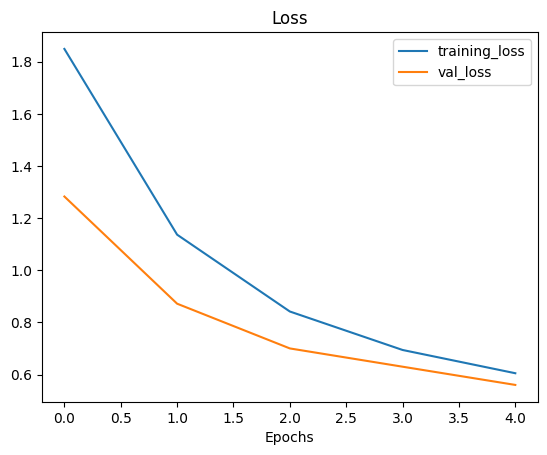

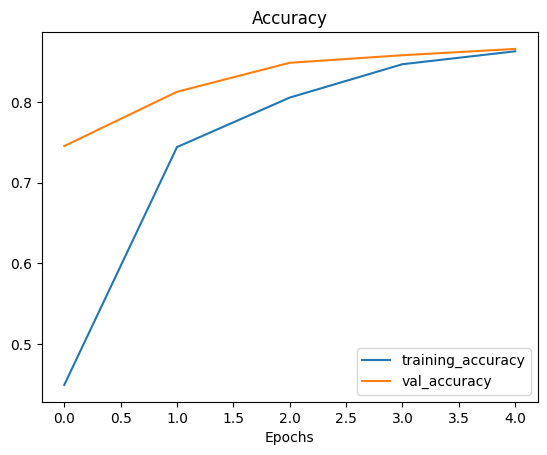

In [19]:
# Loss curves
plot_loss_curves(history_0)

Nice